# Data preparation

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

Image preprocessing: *variant 2*

1) Alignement between panchromatic and SWIR



2) Image tiling 
For each training and label images: (image_ms_pan, image_swir_pan) ~ (3348, 3391, 16), label_image ~ (3348, 3391, 10)
- Divide into tiles with overlapping
- Apply transformations: flip, ... keras preprocessing
- Normalize to [0, 1] 
- Save to file

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import cv2 

In [3]:
import sys
sys.path.append("../common/")

from data_utils import TRAIN_IMAGE_IDS, get_resized_polygons, generate_label_file, LABELS
from image_utils import generate_pansharpened, imwrite, get_filename, generate_aligned_swir
from visu_utils import display_img_1b
from geo_utils.GeoImage import GeoImage
from geo_utils.GeoImageTiler import GeoImageTiler

In [4]:
import os
from image_utils import TRAIN_LABEL_TILES, TRAIN_TILES, get_tile_filename

Generate tiles : 17 bands images and 11 bands labels

In [6]:
tile_size = (512, 512)
overlapping = 64
include_nodata = False

for i, image_id in enumerate(TRAIN_IMAGE_IDS):
    print "--", image_id, i+1, "/", len(TRAIN_IMAGE_IDS)
    
    # Generate aligned swir file
    generate_aligned_swir(image_id)    
    
    # Generate pansharpened
    generate_pansharpened(image_id, 'ms')
    generate_pansharpened(image_id, 'swir_aligned')
    # Generate label image
    generate_label_file(image_id, multi_dim=True)

    gimg_pan = GeoImage(get_filename(image_id, 'pan'))
    gimg_ms = GeoImage(get_filename(image_id, 'ms_pan'))
    gimg_swir = GeoImage(get_filename(image_id, 'swir_pan'))
    gimg_label = GeoImage(get_filename(image_id, 'label'))
    
    gimg_pan_tiles = GeoImageTiler(gimg_pan, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
    gimg_ms_tiles = GeoImageTiler(gimg_ms, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
    gimg_swir_tiles = GeoImageTiler(gimg_swir, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
    gimg_label_tiles = GeoImageTiler(gimg_label, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
    
    for tile_info_pan, tile_info_ms, tile_info_swir, tile_info_label in \
            zip(gimg_pan_tiles, gimg_ms_tiles, gimg_swir_tiles, gimg_label_tiles):
    
        tile_pan, xoffset_pan, yoffset_pan = tile_info_pan
        tile_ms, xoffset_ms, yoffset_ms = tile_info_ms
        tile_swir, xoffset_swir, yoffset_swir = tile_info_swir
        tile_label, xoffset_label, yoffset_label = tile_info_label

        h, w, _ = tile_pan.shape
        x = np.zeros((h, w, 17), dtype=np.uint16)
        x[:,:,0] = tile_pan[:,:,0]; x[:,:,1:9] = tile_ms; x[:,:,9:] = tile_swir
        imwrite(get_tile_filename(image_id, xoffset_ms, yoffset_ms, '17b'), x)
        y = tile_label
        imwrite(get_tile_filename(image_id, xoffset_label, yoffset_label, 'label'), y)    

gimg_pan.close()
gimg_ms.close()
gimg_swir.close()
gimg_label.close()

-- 6040_2_2 1 / 25
-- 6120_2_2 2 / 25
-- 6120_2_0 3 / 25
-- 6090_2_0 4 / 25
-- 6040_1_3 5 / 25
-- 6040_1_0 6 / 25
-- 6100_1_3 7 / 25
-- 6010_4_2 8 / 25
-- 6110_4_0 9 / 25
-- 6140_3_1 10 / 25
-- 6110_1_2 11 / 25
-- 6100_2_3 12 / 25
-- 6150_2_3 13 / 25
-- 6160_2_1 14 / 25
-- 6140_1_2 15 / 25
-- 6110_3_1 16 / 25
-- 6010_4_4 17 / 25
-- 6170_2_4 18 / 25
-- 6170_4_1 19 / 25
-- 6170_0_4 20 / 25
-- 6060_2_3 21 / 25
-- 6070_2_3 22 / 25
-- 6010_1_2 23 / 25
-- 6040_4_4 24 / 25
-- 6100_2_2 25 / 25


In [5]:
gimg_test = GeoImage(TRAIN_TILES + '/6110_3_1_1280_1728.tif')
img = gimg_test.get_data()
print img.shape, img.dtype

gimg_test_label = GeoImage(TRAIN_LABEL_TILES + '/6110_3_1_1280_1728.tif')
img_label = gimg_test_label.get_data()
print img_label.shape, img_label.dtype


(512L, 512L, 17L) uint16
(512L, 512L, 11L) uint8


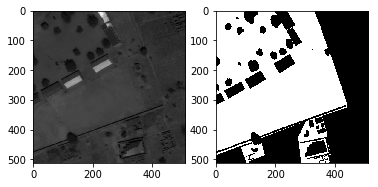

In [6]:
nimg = img * 1.0/2**12
plt.figure()
plt.subplot(121)
plt.imshow(nimg[:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(img_label[:,:,0], cmap='gray')

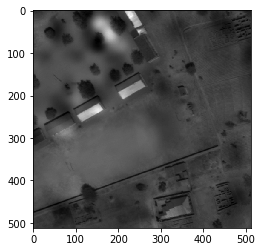

In [16]:
from image_utils import get_image_tile_data

img = get_image_tile_data(TRAIN_TILES + '/6110_3_1_1280_1728.tif')

nimg = img * 1.0/2**12
plt.figure()
plt.imshow(nimg[:,:,16], cmap='gray')

In [10]:
from image_utils import get_image_data
label_img = get_image_data("6100_2_2", 'label')
label_img.shape

(3348, 3391, 11)

In [9]:

def normalize_image(img_data, interp=cv2.INTER_CUBIC):
    img_data = cv2.resize(img_data, dsize=(512, 512), interpolation=interp)
    out = np.zeros_like(img_data)
    for c in range(img_data.shape[2]):        
        min_value, max_value, _, _ = cv2.minMaxLoc(img_data[:,:,c])
        out[:,:,c] = (img_data[:,:,c] - min_value)/(max_value - min_value + 0.0001)            
    out = out.transpose([2,0,1])
    out = out[None,:]
    return out

Generate 1-band labels and 17 bands image tiles

In [5]:
tile_size = (512, 512)
overlapping = 64
include_nodata = True

for i, image_id in enumerate(TRAIN_IMAGE_IDS):
    print "--", image_id, i, "/", len(TRAIN_IMAGE_IDS)
    
    # Generate aligned swir file
    generate_aligned_swir(image_id)    
    
    # Generate pansharpened
    generate_pansharpened(image_id, 'ms')
    generate_pansharpened(image_id, 'swir_aligned')
    # Generate label image
    generate_label_file(image_id, multi_dim=False)

    gimg_pan = GeoImage(get_filename(image_id, 'pan'))
    gimg_ms = GeoImage(get_filename(image_id, 'ms_pan'))
    gimg_swir = GeoImage(get_filename(image_id, 'swir_pan'))
    gimg_label = GeoImage(get_filename(image_id, 'label_1d'))
    
    gimg_pan_tiles = GeoImageTiler(gimg_pan, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
    gimg_ms_tiles = GeoImageTiler(gimg_ms, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
    gimg_swir_tiles = GeoImageTiler(gimg_swir, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
    gimg_label_tiles = GeoImageTiler(gimg_label, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
    
    for tile_info_pan, tile_info_ms, tile_info_swir, tile_info_label in \
            zip(gimg_pan_tiles, gimg_ms_tiles, gimg_swir_tiles, gimg_label_tiles):
    
        tile_pan, xoffset_pan, yoffset_pan = tile_info_pan
        tile_ms, xoffset_ms, yoffset_ms = tile_info_ms
        tile_swir, xoffset_swir, yoffset_swir = tile_info_swir
        tile_label, xoffset_label, yoffset_label = tile_info_label

        h, w, _ = tile_pan.shape
        x = np.zeros((h, w, 17), dtype=np.uint16)
        x[:,:,0] = tile_pan[:,:,0]; x[:,:,1:9] = tile_ms; x[:,:,9:] = tile_swir
        imwrite(get_tile_filename(image_id, xoffset_ms, yoffset_ms, '17b'), x)
        y = tile_label
        imwrite(get_tile_filename(image_id, xoffset_label, yoffset_label, 'label_1d'), y)    

-- 6040_2_2


-- 6120_2_2


-- 6120_2_0


-- 6090_2_0


-- 6040_1_3


-- 6040_1_0


-- 6100_1_3


-- 6010_4_2


-- 6110_4_0


-- 6140_3_1


-- 6110_1_2


-- 6100_2_3


-- 6150_2_3


-- 6160_2_1


-- 6140_1_2


-- 6110_3_1


-- 6010_4_4


-- 6170_2_4


-- 6170_4_1


-- 6170_0_4


-- 6060_2_3


-- 6070_2_3


-- 6010_1_2


-- 6040_4_4


-- 6100_2_2
